# Universalidad de la corrupción
En esta sección se programa el modelo propuesto por los investigadores para recrear las redes de tipo corruptas.

In [ ]:
import numpy as np
import networkx as nx
from pyvis.network import Network

def simulate_corruption_network(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores.

    Parámetros:
    num_iterations (int): Número de iteraciones (escándalos) a simular.
    characteristic_size (float): Tamaño característico de los escándalos de corrupción.
    recidivism_rate (float): Tasa de reincidencia.
    beta (float): Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes.
    p (float): Probabilidad de seleccionar nodos que ya eran reincidentes.

    Devuelve:
    nx.Graph: La red de corrupción simulada.
    """
    
    # Primer paso, se crea un grafo vacío
    graph = nx.Graph()
    total_agents = 0
    recidivists = 0

    for i in range(num_iterations):
        # 1. Escoger el tamaño del escándalo de una distribución exponencial
        scandal_size = int(np.random.exponential(characteristic_size)) + 1  # +1 para evitar tamaño 0
        new_agents = range(total_agents, total_agents + scandal_size)

        # 2. Añadir nuevos agentes al grafo
        graph.add_nodes_from(new_agents)

        # 3. Calcular el número de reincidentes
        r = int(recidivism_rate * total_agents - beta)
        r = max(0, min(r, scandal_size))  # Asegurar que el número de reincidentes sea válido

        # 4. Seleccionar agentes reincidentes
        if total_agents > 0 and r > 0:
            # Determinar cuántos reincidentes nuevos y viejos seleccionar
            num_old_recidivists = int(np.random.binomial(r, p))
            num_new_recidivists = r - num_old_recidivists

            old_recidivists = []
            if num_old_recidivists > 0:
                #Identificar los nodos que ya son reincidentes
                already_recidivists = [node for node, data in graph.nodes(data=True) if data.get('recidivist', False)]
                if already_recidivists:
                    old_recidivists = np.random.choice(already_recidivists, size=min(num_old_recidivists, len(already_recidivists)), replace=False)

            new_recidivists = []
            if num_new_recidivists > 0:
                # Asegurarse de no seleccionar los mismos nodos que old_recidivists
                eligible_nodes = [node for node in graph.nodes() if node not in old_recidivists and node < total_agents]
                if eligible_nodes:
                    new_recidivists = np.random.choice(eligible_nodes, size=min(num_new_recidivists, len(eligible_nodes)), replace=False)

            recidivist_agents = np.concatenate((old_recidivists, new_recidivists))

            # Marcar los nuevos reincidentes como tales
            for agent in new_recidivists:
                graph.nodes[agent]['recidivist'] = True

            # 5. Crear conexiones entre todos los agentes en el escándalo (gráfico completo)
            all_agents = np.concatenate((new_agents, recidivist_agents)).astype(int)
            for agent1 in all_agents:
                for agent2 in all_agents:
                    if agent1 != agent2:
                        graph.add_edge(agent1, agent2)
        else:
            #Si no hay reincidentes, crear conexiones entre los nuevos agentes
            for agent1 in new_agents:
                for agent2 in new_agents:
                    if agent1 != agent2:
                        graph.add_edge(agent1, agent2)

        total_agents += scandal_size
        recidivists += r

    return graph

In [30]:
# Ejemplo de uso con el caso de Brasil

num_iterations = 65  # Número de escándalos en Brasil 
characteristic_size = 7 # Tamaño característico de los escándalos en Brasil
recidivism_rate = 0.14  # Tasa de reincidencia en Brasil
beta = 12 # Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes
p = 0.025 # Probabilidad de seleccionar nodos que ya eran reincidentes

corruption_network_brazil = simulate_corruption_network(num_iterations, characteristic_size, recidivism_rate, beta, p)

print(f"Número de nodos en la red: {corruption_network_brazil.number_of_nodes()}")
print(f"Número de aristas en la red: {corruption_network_brazil.number_of_edges()}")

Número de nodos en la red: 581
Número de aristas en la red: 15378


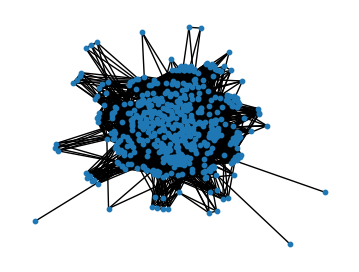

In [31]:
# Visualizar la red creada usando mathplotlib
import matplotlib.pyplot as plt
nx.draw(corruption_network_brazil, with_labels=False, node_size=10)
plt.show()  

In [ ]:
# Visualizar la red creada usando pyvis

from pyvis.network import Network

# Crear una instancia de Network con opciones de visualización personalizadas
net = Network(notebook=True, height='100vh', width="100%", select_menu=True, filter_menu=True)

# Añadir nodos y aristas a la visualización
for node in corruption_network.nodes():
    net.add_node(int(node), label=str(node))

for edge in corruption_network.edges():
    net.add_edge(int(edge[0]), int(edge[1]))

#Mostrar botones de personalización
net.show_buttons()

# Guardar la visualización en un archivo HTML
net.show("corruption_network.html")

corruption_network.html


## Métricas de la red creada con el modelo

Ahora se corroborarán las métricas de la red por medio de la función metricasRed() creada en el archivo 'Métricas a considerar.ipynb'

In [32]:
#Se crea la función que calcula todas las métricas de la red

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community

#Funcion para graficar la red

def mostrarRed(G,nombre):
    
    plt.style.use('science')

    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color='skyblue', edge_color='gray', with_labels=False)
    plt.title(f'Red: {nombre}')
    plt.savefig(f'red_{nombre}.png', dpi=300)
    plt.show()

#Funcion para graficar la distribución de grados

def distribucionDeGrado(G, nombre):
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    degrees = list(dict(nx.degree(G)).values())
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probs = counts / len(G)

    # Eliminar grados con frecuencia cero
    non_zero_probs = probs[probs > 0]
    non_zero_degrees = unique_degrees[probs > 0]

    # Tomar el logaritmo de las probabilidades y los grados
    log_probs = np.log(non_zero_probs)
    log_degrees = np.log(non_zero_degrees)

    # Realizar un ajuste lineal
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_probs)

    # Calcular el exponente de la ley de potencias
    gamma = round(slope,2)
    
    # Crear el gráfico

    plt.style.use('science')

    # Graficar con escala logarítmica únicamente en el eje y (Distribución de grados en una red)
    plt.figure(figsize=(4, 4))

    plt.plot(non_zero_degrees, non_zero_probs, 'o-', color='#3B4285')
    plt.yscale('log')
    plt.xlabel('Grado')
    plt.ylabel('Probabilidad')
    plt.title('Distribución de grados')
    plt.legend()

    plt.savefig(f'distribucion_de_grados_{nombre}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(4, 4)) 

    plt.loglog(unique_degrees, probs, 'o', color='#9FA3D5')
    plt.plot(unique_degrees, np.exp(intercept + slope * np.log(unique_degrees)), '--', label='Ajuste lineal', color='#3B4285')

    plt.xlabel('Grado (log)')
    plt.ylabel('Probabilidad (log)')
    plt.legend()
    plt.title('Distribución de grados (escala logarítmica)')

    # Guardar el gráfico con mayor resolución
    plt.savefig(f'distribucion_de_grados_log_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el exponente
    print("Exponente de la ley de potencias (gamma):", gamma)    

#Función para mostrar la estructura en comunidades

def estructuraComunidades(G, nombre):
    # Detectar comunidades usando el algoritmo de detección de comunidades de Louvain
    comunidades = community.louvain_communities(G)

    # Número de comunidades
    num_comunidades = len(comunidades)
    
    #Cantidad de nodos en cada comunidad
    nodos_comunidad = [len(comunidad) for comunidad in comunidades]
    
    # Promedio de nodos por comunidad
    promedio_nodos = round(np.mean(nodos_comunidad),2)

    # Crear un diccionario de colores para las comunidades
    color_map = {}
    for i, comunidad in enumerate(comunidades):
        for node in comunidad:
            color_map[node] = i
            
    # Crear el gráfico de la red con colores para las comunidades
    plt.figure(figsize=(4, 4)) # Tamaño del gráfico
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color=list(color_map.values()), edge_color='gray', with_labels=False, cmap=plt.cm.tab20)
    plt.title(f'Red: {nombre} (Comunidades)')
    plt.savefig(f'comunidades_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el número de comunidades y el tamaño de cada una
    print(f"Número de comunidades: {num_comunidades}")
    print(f"Número de nodos por comunidad: {nodos_comunidad}")
    print(f"Promedio de nodos por comunidad: {promedio_nodos}")
    
    #Distribución de tamaños de comunidades
         
# Propiedad de mundo pequeño

def mundoPequeno(G, nombre):
    
    # Calcular el coeficiente de agrupamiento global
    clustering_coeff = round(nx.average_clustering(G),2)
    
    # Calcular el camino medio más corto
    try:
        average_path_length = round(nx.average_shortest_path_length(G),2)
    except nx.NetworkXError:
        average_path_length = round(float('inf'),2)

    print(f"Coeficiente de agrupamiento: {clustering_coeff}")
    print(f"Camino medio más corto: {average_path_length}")
    
    if  (clustering_coeff > .90 and average_path_length < 5):
        print(f"La red '{nombre}' tiene la propiedad de mundo pequeño.")
    else:
        print(f"La red '{nombre}' no tiene la propiedad de mundo pequeño.")
    
#Asortaividad

def asortatividad(G):
    # Calcular el coeficiente de asortatividad de grado
    assortativity_coeff = round(nx.degree_assortativity_coefficient(G),2)
    # Imprimir el coeficiente de asortatividad
    print(f"Coeficiente de Asortatividad: {assortativity_coeff}")
 
def densidad(G):
    # Calcular la densidad de la red
    density = round(nx.density(G), 2)
    # Imprimir la densidad
    print(f"Densidad de la red: {density}")
    
#Función global que calcula todas las métricas
            
def metricasRed(G, Nombre):
    # Mostrar la red
    mostrarRed(G, Nombre)
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    distribucionDeGrado(G, Nombre)
    # Estructura en comunidades
    estructuraComunidades(G, Nombre)
    # Propiedad de mundo pequeño
    mundoPequeno(G, Nombre)
    # Asortatividad
    asortatividad(G)
    # Densidad
    densidad(G)

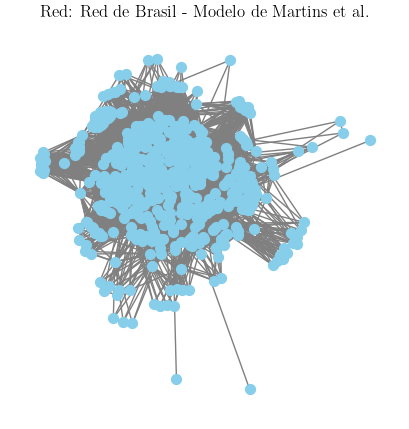

C:\Users\Tierra\AppData\Local\Temp\ipykernel_204\1587543762.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


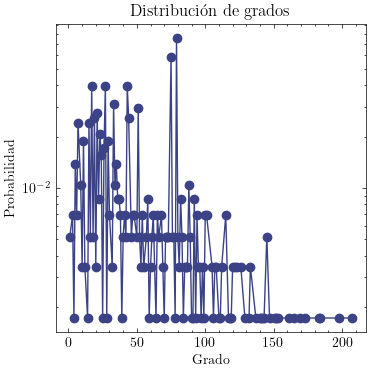

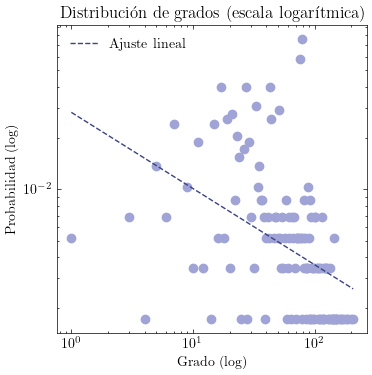

Exponente de la ley de potencias (gamma): -0.45


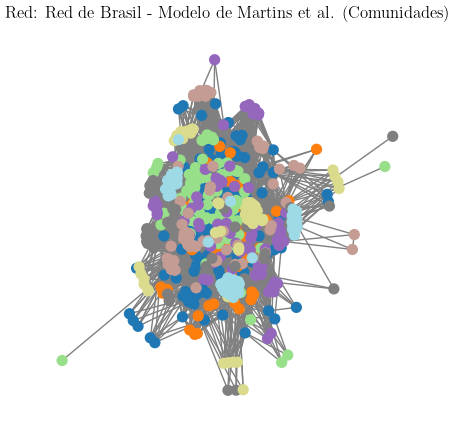

Número de comunidades: 8
Número de nodos por comunidad: [120, 43, 83, 82, 70, 36, 67, 80]
Promedio de nodos por comunidad: 72.62
Coeficiente de agrupamiento: 0.79
Camino medio más corto: 2.14
La red 'Red de Brasil - Modelo de Martins et al.' no tiene la propiedad de mundo pequeño.
Coeficiente de Asortatividad: 0.23
Densidad de la red: 0.09


In [33]:
#Calcular las métricas de la red de corrupción de Brasil
Nombre = 'Red de Brasil - Modelo de Martins et al.'
metricasRed(corruption_network_brazil, Nombre)